# Mean Reversion on Futures
by Rob Reider and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)



Introducing futures as an asset opens up trading opportunities that were previously unavailable.  In this lecture we will look at strategies involving one future against another. We will also look at strategies involving trades of futures and stocks at the same time. Other strategies, like trading calendar spreads (futures on the same commodity but with different delivery months) will be topics for future lectures.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
from quantopian.research.experimental import continuous_future, history

## Pairs of Futures (or Spreads)
Before we look at trading pairs of futures contracts, let's quickly review pairs trading in general and cointegration.  For full lectures on these topics individually, see the [lecture on stationarity and cointegration](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity) and the [lecture on pairs trading](https://www.quantopian.com/lectures/introduction-to-pairs-trading).

When markets are efficient, the prices of assets are often modeled as [random walks](https://en.wikipedia.org/wiki/Random_walk_hypothesis):

$$P*t=\mu+P*{t-1}+\epsilon_t$$

We can then take the difference of the prices to get white noise, stationary time series:

$$r*t=P_t-P*{t-1}= \mu +\epsilon_t$$

Of course, if prices follow a random walk, they are completely unforecastable, so the goal is to find returns that are correlated with something in the past.  For example, if we can find an asset whose price is a little mean-reverting (and therefore its returns are negatively autocorrelated), we can use that to forecast future returns.

## Cointegration and Mean Reversion
The idea behind cointegration is that even if the prices of two different assets both follow random walks, it is still possible that a linear combination of them is not a random walk. A common analogy is of a dog owner walking his dog with a retractable leash. If you look at the position of the dog owner, it may follow a random walk, and if you look at the dog separately, it also may follow a random walk, but the distance between them, the difference of their positions, may very well be mean reverting. If the dog is behind the owner, he may run to catch up and if the dog is ahead, the length of the leash may prevent him from getting too far away. 

The dog and its owner are linked together and their distance is a mean reverting process.  In cointegration, we look for assets that are economically linked, so that if $P_t$ and $Q_t$ are both random walks, the linear combination, $P_t - b Q_t$, may not itself be a random walk and may be forecastable.

## Finding a Feasible Spread
For stocks, a natural starting point for identifying cointegrated pairs is looking at stocks in the same industry. However, competitors are not necessarily economic substitutes. Think of Apple and Blackberry.  It's not always the case that when one of those company's stock price jumps up, the other catches up. The economic link is fairly tenuous. Here it is more like the dog broke the leash and ran away from the owner.

However, with pairs of futures, there may be economic forces that link the two prices. Consider heating oil and natural gas. Some power plants have the ability to use either one, depending on  which has become cheaper. So when heating oil has dipped below natural gas, increased demand for heating oil will push it back up. Platinum and Palladium are substitutes for some types of catalytic converters used for emission control. Corn and wheat are substitutes for animal feed. Corn and sugar are substitutes as sweeteners. There are many potential links to examine and test.

Let's go through a specific example of futures prices that might be cointegrated.  

## Soybean Crush
The difference in price between soybeans and their refined products is referred to as the "crush spread".  It represents the processing margin from "crushing" a soybean into its refined products. Note that we scale up the futures price of soybean oil so that it is the same magnitude as the price for soybean meal. It certainly seems from the plots that the prices of the refined products move together. 

In [2]:
soy_meal_mult = symbols('SMF17').multiplier
soy_oil_mult = symbols('BOF17').multiplier
soybean_mult = symbols('SYF17').multiplier

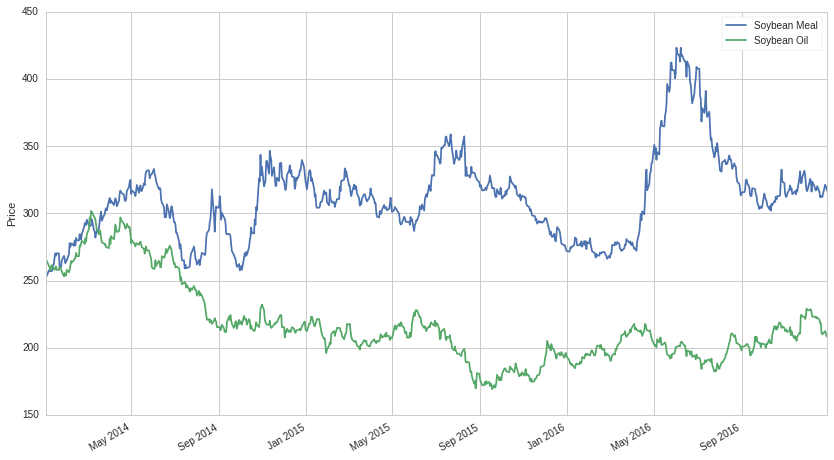

In [3]:
sm_future = continuous_future('SM', offset=0, roll='calendar', adjustment='mul')
sm_price = history(sm_future, fields='price', start_date='2014-01-01', end_date='2017-01-01')

bo_future = continuous_future('BO', offset=0, roll='calendar', adjustment='mul')
bo_price = history(bo_future, fields='price', start_date='2014-01-01', end_date='2017-01-01')

sm_price.plot()
bo_price.multiply(soy_oil_mult//soy_meal_mult).plot()
plt.ylabel('Price')
plt.legend(['Soybean Meal', 'Soybean Oil']);

However, from looking at the p-value for our test, we conclude that soybean meal and soybean meal and soybean oil are not cointegrated.

In [4]:
print 'p-value: ', coint(sm_price, bo_price)[1]

p-value:  0.228842012164


We still have this compelling economic link, though. Both soybean oil and soybean meal have a root product in soybeans themselves. Let's see if we can suss out any signal by creating a spread between soybean prices and the refined products together, by implementing the [crush spread](https://en.wikipedia.org/wiki/Crush_spread).

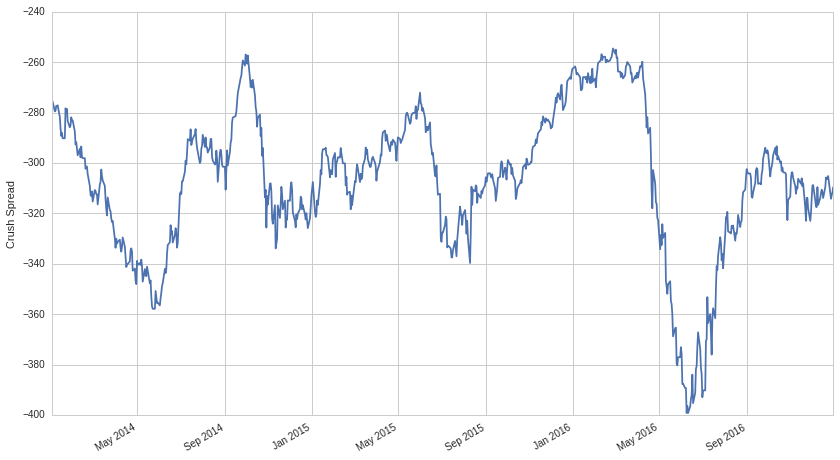

In [5]:
sm_future = continuous_future('SM', offset=1, roll='calendar', adjustment='mul')
sm_price = history(sm_future, fields='price', start_date='2014-01-01', end_date='2017-01-01')

bo_future = continuous_future('BO', offset=1, roll='calendar', adjustment='mul')
bo_price = history(bo_future, fields='price', start_date='2014-01-01', end_date='2017-01-01')

sy_future = continuous_future('SY', offset=0, roll='calendar', adjustment='mul')
sy_price = history(sy_future, fields='price', start_date='2014-01-01', end_date='2017-01-01')

crush = sy_price - (sm_price + bo_price)
crush.plot()
plt.ylabel('Crush Spread');

In the above plot, we offset the refined products by one month to roughly match the time it takes to crush the soybeans and we set `roll='calendar'` so that all three contracts are rolled at the same time.

To test whether this spread is stationary, we will use the augmented Dickey-Fuller test.

In [6]:
print 'p-value for stationarity: ', adfuller(crush)[1]

p-value for stationarity:  0.0253387237046


The test confirms that the spread is stationary. And it makes sense, economically, that the crush spread may exhibit some mean reversion due to simple supply and demand.

Note that there is usually a little more finesse required to obtain a mean reverting spread. We usually find a linear combination that would make the spread between the assets stationary after discovering cointegration. For more details on this, see the [lecture on cointegration](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity). We skipped these steps to test this known spread off the bat.

Here are a few other examples of economically-linked futures:

* **3:2:1 Crack Spread**: Buy three crude oil, sell two gasoline, Sell one heating oil (this represents the profitability of oil refining)
* **8:4:3 Cattle Crush** Buy 8 October live-cattle, Sell 4 May feeder cattle, Sell 3 July corn (this represents the profitability of fattening feeder cattle, where the 3 corn contracts are enough to feed the young feeder cattle)

For widely-followed spreads like the crush spread or the crack spread, it would be surprising if the depth of mean reversion became so large that you could easily profit from it. If we consider futures that are linked to stocks, however, the number of potential pairs grows.

## Futures and Stocks
There are many examples of potential relationships between futures and stocks. We already discussed one of them - the relationship between the crush spread and the price of soybean processors. Here are several more, though this is not meant to be a complete list:

* Crude oil futures and oil stocks
* Gold futures and gold mining stocks
* Crude oil futures and airline stocks
* Currency futures and exporters
* Interest rate futures and utilities
* Interest rate futures and Real Estate Investment Trusts (REITs)
* Corn futures and agricultural processing companies (e.g., ADM)

Consider the relationship between ten-year interest rate futures and the price of EQR, a large REIT. Interest rates heavily influence the value of real estate, so there is a strong economic connection between the value of interest rate futures and the value of REITs.

In [7]:
ty_future = continuous_future('TY', offset=0, roll='calendar', adjustment='mul')
ty_prices = history(ty_future, fields='price', start_date='2009-01-01', end_date='2017-01-01')
ty_prices.name = ty_future.root_symbol

equities = symbols(['EQR', 'SPY'])
equity_prices = get_pricing(equities, fields='price', start_date='2009-01-01', end_date='2017-01-01')
equity_prices.columns = map(lambda x: x.symbol, equity_prices.columns)

data = pd.concat([ty_prices, equity_prices], axis=1)
data = data.dropna()

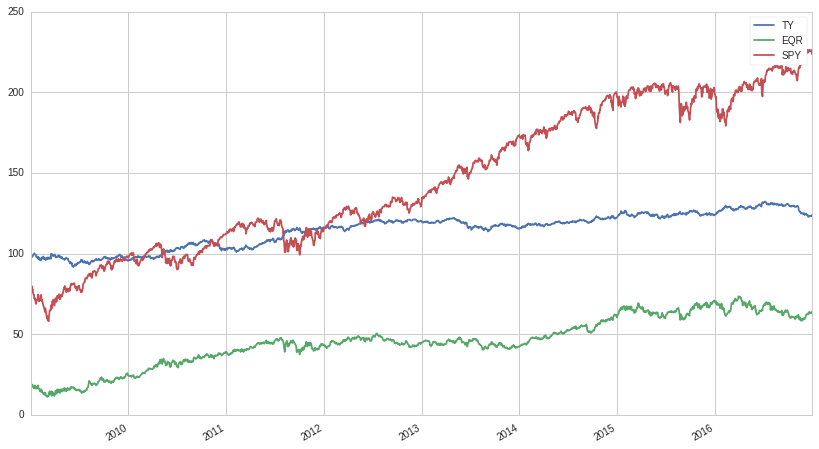

In [8]:
data.plot()
plt.legend();

If we apply a hypothesis test to the two price series we find that they are indeed cointegrated, corroborating our economic hypothesis.

In [9]:
print 'Cointegration test p-value: ', coint(data['TY'], data['EQR'])[1]

Cointegration test p-value:  0.0299261276671


The next step would be to test if this signal is viable once we include market impact by trading EQR against the futures contract as a pair in a backtest.

Trading strategies based on cointegrated pairs form buy and sell signals based on the *relative prices* of the pair.  We can also form trading signals based on *changes in prices*, or returns.  Of course we would expect that changes in futures prices to be contemporaneously correlated with stock prices, which is not forecastable.  If crude oil prices rise today, oil company stocks are likely to rise today also.  But perhaps there are lead/lag effects also between changes in futures and stocks returns.  We know there is evidence that the market can systematically underreact or overreact to other news releases, leading to trending and mean reversion.  Let's look at a few examples with futures.

The first example looks at crude oil futures and oil company stocks.

In [13]:
cl_future = continuous_future('CL', offset=0, roll='calendar', adjustment='mul')
cl_prices = history(cl_future, fields='price', start_date='2007-01-01', end_date='2017-04-06')
cl_prices.name = cl_future.root_symbol

equities = symbols(['XOM', 'SPY'])
equity_prices = get_pricing(equities, fields='price', start_date='2007-01-01', end_date='2017-04-06')
equity_prices.columns = map(lambda x: x.symbol, equity_prices.columns)

data = pd.concat([cl_prices, equity_prices],axis=1)
data = data.dropna()

In [23]:
#Take log of prices
data['stock_ret'] = np.log(data['XOM']).diff()
data['spy_ret'] = np.log(data['SPY']).diff()
data['futures_ret'] = np.log(data['CL']).diff()

# Compute excess returns in excess of SPY
data['stock_excess'] = data['stock_ret'] - data['spy_ret']

#Compute lagged futures returns
data['futures_lag_diff'] = data['futures_ret'].shift(1)
data = data[2:].dropna()
data.tail(5)

,CL,XOM,SPY,stock_ret,futures_ret,spy_ret,stock_excess,futures_lag,futures_lag_diff
2017-03-31 00:00:00+00:00,50.85,82.00,235.72,-0.020281,0.010279,-0.002331,-0.017950,0.014610,0.014610
2017-04-03 00:00:00+00:00,50.25,82.08,235.37,0.000975,-0.011870,-0.001486,0.002461,0.010279,0.010279
2017-04-04 00:00:00+00:00,51.13,82.35,235.50,0.003284,0.017361,0.000552,0.002732,-0.011870,-0.011870
2017-04-05 00:00:00+00:00,50.82,82.53,234.77,0.002183,-0.006081,-0.003105,0.005288,0.017361,0.017361
2017-04-06 00:00:00+00:00,51.74,83.02,235.39,0.005920,0.017941,0.002637,0.003282,-0.006081,-0.006081


We have a high positive contemporaneous correlation, but a slightly negative lagged correlation.

In [24]:
#Compute contemporaneous correlation
contemp_corr = data['stock_excess'].shift(1).corr(data['futures_lag_diff'])
#Compute correlation of excess stock returns with lagged futures returns
lagged_corr = data['stock_excess'].corr(data['futures_lag_diff'])
print 'Contemporaneous correlation: ', contemp_corr
print 'Lagged correlation         : ', lagged_corr

Contemporaneous correlation:  0.257312975324
Lagged correlation         :  -0.0519203748947


And when we form a linear regression of the excess returns of XOM on the lagged futures returns, the coefficient is significant and negative. This and the above correlations indicate that there might be a slight overreaction to the shift in oil prices.

In [35]:
result = sm.OLS(data['stock_excess'], sm.add_constant(data['futures_lag_diff'])).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.002      
Dependent Variable: stock_excess     AIC:                -16587.6204
Date:               2017-04-25 18:21 BIC:                -16575.9124
No. Observations:   2576             Log-Likelihood:     8295.8     
Df Model:           1                F-statistic:        6.958      
Df Residuals:       2574             Prob (F-statistic): 0.00840    
R-squared:          0.003            Scale:              9.3463e-05 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                -0.0001   0.0002 -0.6881 0.4914 -0.0005  0.0002
futures_lag_diff     -0.0216   0.0082 -2.6377 0.0084 -0.0377 -0.0055
--------------------------------------------------------------------
Omnibus:              412.749       Durbin-Watson:          1.950   
Prob(Omnibus):        0.000         Jarque-Bera (JB):       6879.407
Skew:                 -0.156        Prob(JB):               0.000   
Kurtosis:             11.000        Condition No.:          43      
====================================================================

"""

A coefficient of around $-0.02$ on the lagged futures return implies that if the oil price increased by 1% yesterday, the pure-play refiner is expected to go down by $2$ bp today. This would require more testing to formulate a functioning model, but it indicates that there might be some signal in drawing out the underreaction or overreaction of equity prices to changes in futures prices.

This conjecture could be total data mining, but perhaps when the connection between the futures and stock is exceedingly obvious, like oil stocks and oil exploration companies or gold stocks and gold miners, the market overreacts to fundamental information, but when the relationship is more subtle, the market underreacts.

Also, there may be other lead/lag effects over longer time scales than one-day, but as always, this could also lead to more data mining.

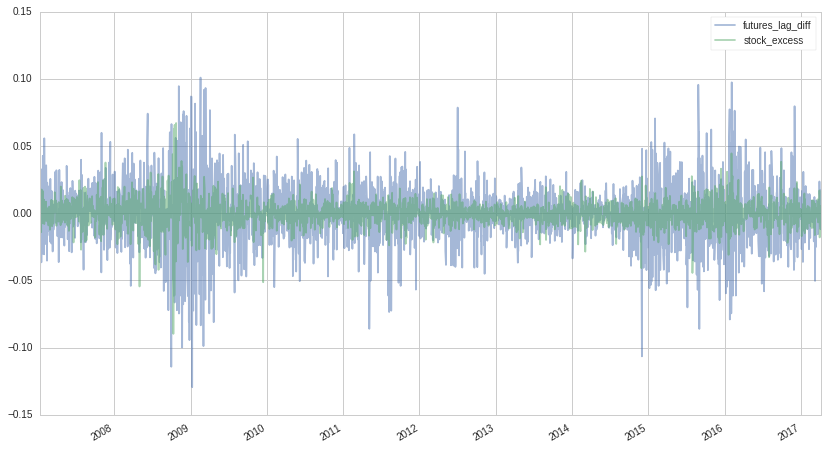

In [19]:
data['futures_lag_diff'].plot(alpha=0.50, legend=True)
data['stock_excess'].plot(alpha=0.50, legend=True);

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*